# Benchmark com Microsoft GrabCut (50 imagens)

Utilizando a métrica _error rate_, esse notebook propõe-se construir uma avaliação no dataset grabcut para avaliar a taxa de erro médio para o algoritmo EGSIS. A intenção é realizar uma comparação com as técnicas avaliadas no artigo _Segmentation by t

O. Duchenne, J. -Y. Audibert, R. Keriven, J. Ponce and F. Segonne, "Segmentation by transduction," 2008 IEEE Conference on Computer Vision and Pattern Recognition, Anchorage, AK, USA, 2008, pp. 1-8, doi: 10.1109/CVPR.2008.4587419.

In [1]:
import os
os.environ["LOGURU_LEVEL"] = "ERROR"

In [27]:
from egsis.datasets import grabcut
import matplotlib.pyplot as plt
from egsis import model
from egsis import metrics
from egsis import image

# Avaliação única aleatória

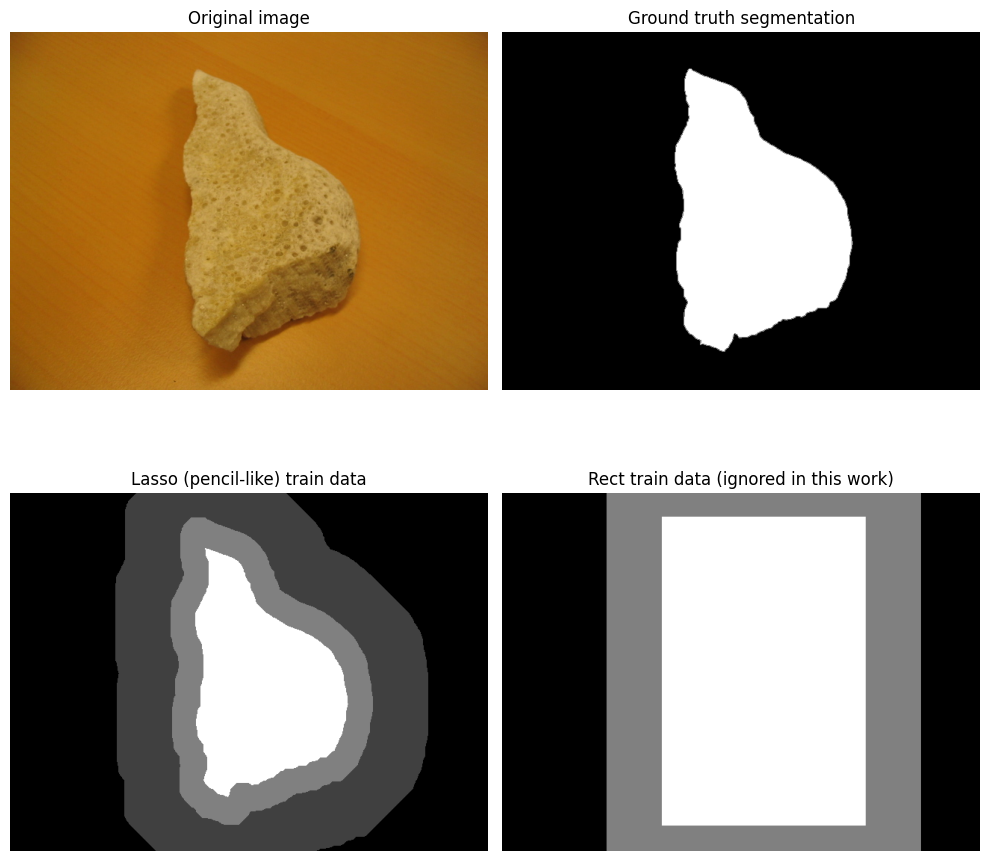

In [63]:
# img = grabcut.get_random_image()
img = grabcut.get_labeled_image_by_name("stone1.JPG")
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(img.lasso, cmap="gray")
ax[1, 0].set_title("Lasso (pencil-like) train data")
ax[1, 1].imshow(img.rect, cmap="gray")
ax[1, 1].set_title("Rect train data (ignored in this work)")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Labelling description 

**Segmentation**: A tri-map which specifies background (0), foreground (255) and
mixed area (128). The mixed area contains pixels which are a combination of foreand background texture. Note, in low contrast regions the true boundary is not
observed and the ground truth is in this case a "good guess".

**Labelling-Lasso**: Imitates a tri-map obtained by a lasso or pen tool. The colour
coding is: 

- background (0);
- background - used for colour model training (64);
- inference (unknown) region (128);
- foreground - used for colour model training (255).

Note, a lasso tool can be imitated by specifying the foreground region (255) as unknown
(128).

**Labelling-Rectangle**: Imitates a tri-map obtained by two mouse clicks (rectangle).
Same colour coding as in Labelling-Lasso.

In [64]:
# Preprocessing labeling scheme
# y_train = img.lasso
# y_train[y_train == 64] = 1 # background
# y_train[y_train == 128] = 0 # means unlabelled for egsis
# y_train[y_train == 255] = 2 # foreground
# y_true = img.segmentation
# y_true[y_true == 128] = 1
# y_true[y_true == 255] = 1

# not more necessary the steps above, replaced by:
y_train = img.y_train()
y_true = img.y_true()

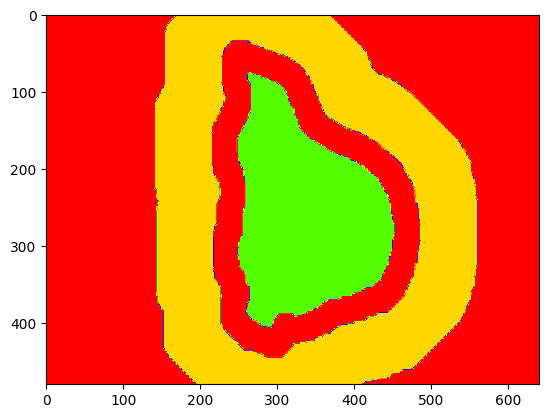

In [65]:
plt.imshow(y_train, cmap="prism")  

# the green region it's training data for background
# the yellow region it's training data for foreground

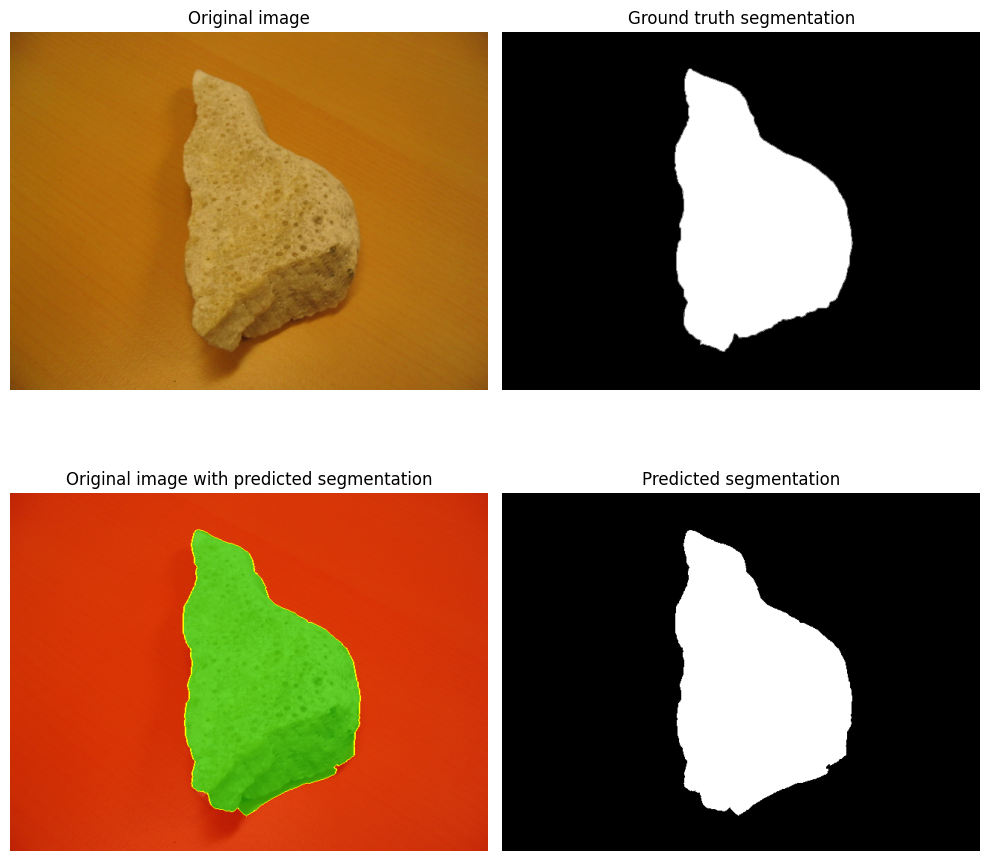

In [66]:
X = img.data
y = y_train

m = model.EGSIS(
    superpixel_segments=200,
    superpixel_sigma=0.3,
    superpixel_compactness=40,
    feature_extraction="gabor",
    lcu_max_iter=100,
    feature_similarity="manhattan_log",
)

# Fit predict receiving a image mask
# re-encoding y-values to be in {0,1} because for EGSIS, y=0 means non-labeled
mask = m.fit_predict_segmentation_mask(X, y) - 1

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
labels_by_color = {
    0: "#ff0000", # background red
    1: "#00ff00" # foreground green
}
ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(image.segmentation_mask_blend(img.data, mask, labels_by_color))
ax[1, 0].set_title("Original image with predicted segmentation")
ax[1, 1].imshow(mask, cmap="gray")
ax[1, 1].set_title("Predicted segmentation")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [69]:
y_pred = mask
err = metrics.err(y_true, y_pred) * 100
iou = metrics.iou(y_true, y_pred)
f1 = metrics.f1(y_true, y_pred)
acc = metrics.pixel_accuracy(y_true, y_pred)
print("Segmentation Metrics!")
print(f"Err:\t{round(err, 2)}%") 
print(f"IoU:\t{round(iou, 2)}") 
print(f"F1:\t{round(f1, 2)}") 
print(f"acc:\t{round(acc, 2)}") 

Segmentation Metrics!
Err:	2.75%
IoU:	0.96
F1:	0.19
acc:	0.99


# Avaliação em Lote

In [70]:
%%time
import pandas as pd
imgs = grabcut.get_all_dataset()
stats = []
for img in imgs:
    X = img.data
    y_true = img.y_true()
    y_train = img.y_train()
    mask = m.fit_predict_segmentation_mask(X, y_train)
    # label re-encoding
    y_pred = mask - 1
    err = metrics.err(y_true, y_pred) * 100
    iou = metrics.iou(y_true, y_pred)
    f1 = metrics.f1(y_true, y_pred)
    acc = metrics.pixel_accuracy(y_true, y_pred)
    stat = [img.fname, err, iou, f1, acc]
    stats.append(stat)

df = pd.DataFrame(stats, columns=["name", "err", "iou", "f1", "acc"])
df.sort_values(by="err")

CPU times: user 32min 39s, sys: 17min 45s, total: 50min 24s
Wall time: 19min 58s


,name,err,iou,f1,acc
48,fullmoon.bmp,0.010255,0.894688,0.056399,0.993361
32,flower.jpg,0.027763,0.889201,0.177985,0.977822
39,teddy.jpg,0.062078,0.869551,0.186000,0.972096
46,elefant.bmp,0.209551,0.933357,0.310928,0.977799
27,tennis.jpg,0.498339,0.614970,0.055178,0.965453
15,stone2.JPG,0.674796,0.941387,0.234538,0.985397
13,person4.jpg,0.710971,0.948863,0.177719,0.990422
14,388016.jpg,0.775162,0.700979,0.112732,0.951911
2,271008.jpg,0.991560,0.825327,0.117052,0.975227
24,227092.jpg,1.139950,0.920171,0.383877,0.966697


In [71]:
df.describe()

,err,iou,f1,acc
count,50.000000,50.000000,50.000000,50.000000
mean,3.583010,0.846416,0.190536,0.971848
std,3.025100,0.099026,0.113663,0.014832
min,0.010255,0.614970,0.048359,0.930978
25%,1.635655,0.786493,0.108215,0.963232
50%,2.504064,0.866843,0.166878,0.972201
75%,5.435162,0.930240,0.234068,0.982934
max,13.072596,0.959136,0.526972,0.993989
